# Gym Member Churn Prediction Model

This notebook builds a machine learning model to predict which gym members are at risk of cancelling their membership.

**Approach:**
1. Load user information and visit data
2. Engineer features from visit patterns (frequency, recency, trends)
3. Combine with user demographics
4. Train a classification model
5. Analyze feature importance to understand churn drivers


In [1]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load data
data_dir = Path.cwd().parent / 'data'

users_df = pd.read_csv(data_dir / 'user_information.csv', parse_dates=['REGISTRATION_DATE', 'MEMBERSHIP_END_DATE'])
visits_df = pd.read_csv(data_dir / 'user_visits.csv', parse_dates=['ENTRY_TIME', 'EXIT_TIME'])

print(f"Users: {len(users_df)}")
print(f"Visits: {len(visits_df)}")
print(f"\nUsers columns: {users_df.columns.tolist()}")
print(f"\nChurned: {users_df['MEMBERSHIP_END_DATE'].notna().sum()}")
print(f"Active: {users_df['MEMBERSHIP_END_DATE'].isna().sum()}")


Users: 300
Visits: 3903

Users columns: ['USER_ID', 'REGISTRATION_DATE', 'MEMBERSHIP_END_DATE', 'AGE', 'GENDER', 'ZUMBA', 'BODY_PUMP', 'PILATES', 'SPINNING']

Churned: 110
Active: 190


## Feature Engineering

We'll create features that capture user behavior patterns:
- **Visit frequency**: total visits, visits per month
- **Recency**: days since last visit
- **Session patterns**: average duration, preferred hours
- **Trends**: is visit frequency declining?
- **Demographics**: age, gender, class enrollments


In [3]:
def engineer_features(users_df, visits_df):
    """
    Create features for churn prediction from user and visit data.
    """
    # Reference date (use today for active users, end date for churned)
    reference_date = datetime.now()
    
    # Calculate visit-based features for each user
    visit_features = []
    
    for user_id in users_df['USER_ID']:
        user_visits = visits_df[visits_df['USER_ID'] == user_id].copy()
        user_info = users_df[users_df['USER_ID'] == user_id].iloc[0]
        
        # Determine reference date for this user
        if pd.notna(user_info['MEMBERSHIP_END_DATE']):
            ref_date = user_info['MEMBERSHIP_END_DATE']
            churned = 1
        else:
            ref_date = reference_date
            churned = 0
        
        registration_date = user_info['REGISTRATION_DATE']
        membership_duration_days = (ref_date - registration_date).days
        
        if len(user_visits) == 0:
            visit_features.append({
                'USER_ID': user_id,
                'CHURNED': churned,
                'total_visits': 0,
                'visits_per_month': 0,
                'avg_session_duration_min': 0,
                'days_since_last_visit': membership_duration_days,
                'avg_days_between_visits': 0,
                'std_days_between_visits': 0,
                'visits_last_30_days': 0,
                'visits_last_60_days': 0,
                'visits_last_90_days': 0,
                'pct_peak_hour_visits': 0,
                'pct_weekend_visits': 0,
                'visit_frequency_trend': 0,
                'membership_duration_months': membership_duration_days / 30
            })
            continue
        
        # Sort visits by time
        user_visits = user_visits.sort_values('ENTRY_TIME')
        
        # Total visits
        total_visits = len(user_visits)
        
        # Visits per month
        months_active = max(1, membership_duration_days / 30)
        visits_per_month = total_visits / months_active
        
        # Session duration
        user_visits['duration_min'] = (user_visits['EXIT_TIME'] - user_visits['ENTRY_TIME']).dt.total_seconds() / 60
        avg_session_duration = user_visits['duration_min'].mean()
        
        # Days since last visit (from reference date)
        last_visit = user_visits['ENTRY_TIME'].max()
        days_since_last_visit = (ref_date - last_visit).days
        
        # Days between visits
        if len(user_visits) > 1:
            user_visits['days_since_prev'] = user_visits['ENTRY_TIME'].diff().dt.days
            avg_days_between = user_visits['days_since_prev'].mean()
            std_days_between = user_visits['days_since_prev'].std()
        else:
            avg_days_between = 0
            std_days_between = 0
        
        # Visits in last X days (before reference date)
        visits_last_30 = len(user_visits[user_visits['ENTRY_TIME'] >= ref_date - timedelta(days=30)])
        visits_last_60 = len(user_visits[user_visits['ENTRY_TIME'] >= ref_date - timedelta(days=60)])
        visits_last_90 = len(user_visits[user_visits['ENTRY_TIME'] >= ref_date - timedelta(days=90)])
        
        # Peak hour visits (5pm-8pm)
        user_visits['hour'] = user_visits['ENTRY_TIME'].dt.hour
        peak_visits = len(user_visits[(user_visits['hour'] >= 17) & (user_visits['hour'] < 20)])
        pct_peak_hour = peak_visits / total_visits if total_visits > 0 else 0
        
        # Weekend visits
        user_visits['weekday'] = user_visits['ENTRY_TIME'].dt.weekday
        weekend_visits = len(user_visits[user_visits['weekday'] >= 5])
        pct_weekend = weekend_visits / total_visits if total_visits > 0 else 0
        
        # Visit frequency trend (compare first half vs second half of membership)
        mid_date = registration_date + timedelta(days=membership_duration_days / 2)
        first_half_visits = len(user_visits[user_visits['ENTRY_TIME'] < mid_date])
        second_half_visits = len(user_visits[user_visits['ENTRY_TIME'] >= mid_date])
        
        if first_half_visits > 0:
            visit_frequency_trend = (second_half_visits - first_half_visits) / first_half_visits
        else:
            visit_frequency_trend = 0
        
        visit_features.append({
            'USER_ID': user_id,
            'CHURNED': churned,
            'total_visits': total_visits,
            'visits_per_month': visits_per_month,
            'avg_session_duration_min': avg_session_duration,
            'days_since_last_visit': days_since_last_visit,
            'avg_days_between_visits': avg_days_between,
            'std_days_between_visits': std_days_between if not pd.isna(std_days_between) else 0,
            'visits_last_30_days': visits_last_30,
            'visits_last_60_days': visits_last_60,
            'visits_last_90_days': visits_last_90,
            'pct_peak_hour_visits': pct_peak_hour,
            'pct_weekend_visits': pct_weekend,
            'visit_frequency_trend': visit_frequency_trend,
            'membership_duration_months': membership_duration_days / 30
        })
    
    features_df = pd.DataFrame(visit_features)
    
    # Merge with user demographics
    user_demographics = users_df[['USER_ID', 'AGE', 'GENDER', 'ZUMBA', 'BODY_PUMP', 'PILATES', 'SPINNING']].copy()
    features_df = features_df.merge(user_demographics, on='USER_ID')
    
    # Encode gender
    features_df['GENDER'] = (features_df['GENDER'] == 'M').astype(int)
    
    # Convert boolean columns to int
    for col in ['ZUMBA', 'BODY_PUMP', 'PILATES', 'SPINNING']:
        features_df[col] = features_df[col].astype(int)
    
    # Count total classes enrolled
    features_df['num_classes_enrolled'] = features_df[['ZUMBA', 'BODY_PUMP', 'PILATES', 'SPINNING']].sum(axis=1)
    
    return features_df

# Create features
print("Engineering features...")
features_df = engineer_features(users_df, visits_df)
print(f"Features created: {features_df.shape}")
features_df.head()


Engineering features...
Features created: (300, 22)


,USER_ID,CHURNED,total_visits,visits_per_month,avg_session_duration_min,days_since_last_visit,avg_days_between_visits,std_days_between_visits,visits_last_30_days,visits_last_60_days,...,pct_weekend_visits,visit_frequency_trend,membership_duration_months,AGE,GENDER,ZUMBA,BODY_PUMP,PILATES,SPINNING,num_classes_enrolled
0,93810,1,20,20.000000,60.700000,4,0.842105,1.067872,20,20,...,0.300000,-0.333333,1.000000,62,0,0,0,0,1,1
1,24592,0,9,0.586957,76.666667,49,49.375000,58.216192,0,3,...,0.222222,-0.200000,15.333333,20,0,0,0,0,0,0
2,13278,1,11,1.586538,67.454545,4,14.900000,11.948501,1,5,...,0.090909,1.666667,6.933333,34,1,0,0,0,0,0
3,46048,1,11,2.972973,57.363636,11,7.700000,6.634087,5,7,...,0.181818,0.750000,3.700000,61,0,0,0,0,0,0
4,42098,0,5,0.320513,51.200000,28,81.250000,97.595680,1,1,...,0.800000,-0.750000,15.600000,62,1,0,0,0,0,0


## Train the Model

We'll use a Random Forest classifier - it handles non-linear relationships well and provides feature importance.


In [4]:
# Prepare data for training
feature_columns = [
    'total_visits', 'visits_per_month', 'avg_session_duration_min',
    'days_since_last_visit', 'avg_days_between_visits', 'std_days_between_visits',
    'visits_last_30_days', 'visits_last_60_days', 'visits_last_90_days',
    'pct_peak_hour_visits', 'pct_weekend_visits', 'visit_frequency_trend',
    'membership_duration_months', 'AGE', 'GENDER',
    'ZUMBA', 'BODY_PUMP', 'PILATES', 'SPINNING', 'num_classes_enrolled'
]

X = features_df[feature_columns]
y = features_df['CHURNED']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nChurn rate in training: {y_train.mean()*100:.1f}%")
print(f"Churn rate in test: {y_test.mean()*100:.1f}%")


Training set: 225 samples
Test set: 75 samples

Churn rate in training: 36.9%
Churn rate in test: 36.0%


In [5]:
# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== MODEL PERFORMANCE ===\n")
print(classification_report(y_test, y_pred, target_names=['Active', 'Churned']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")


=== MODEL PERFORMANCE ===

              precision    recall  f1-score   support

      Active       0.71      0.73      0.72        48
     Churned       0.50      0.48      0.49        27

    accuracy                           0.64        75
   macro avg       0.61      0.61      0.61        75
weighted avg       0.64      0.64      0.64        75


ROC-AUC Score: 0.673


## Feature Importance

Understanding which features drive churn predictions helps identify at-risk users and design retention strategies.


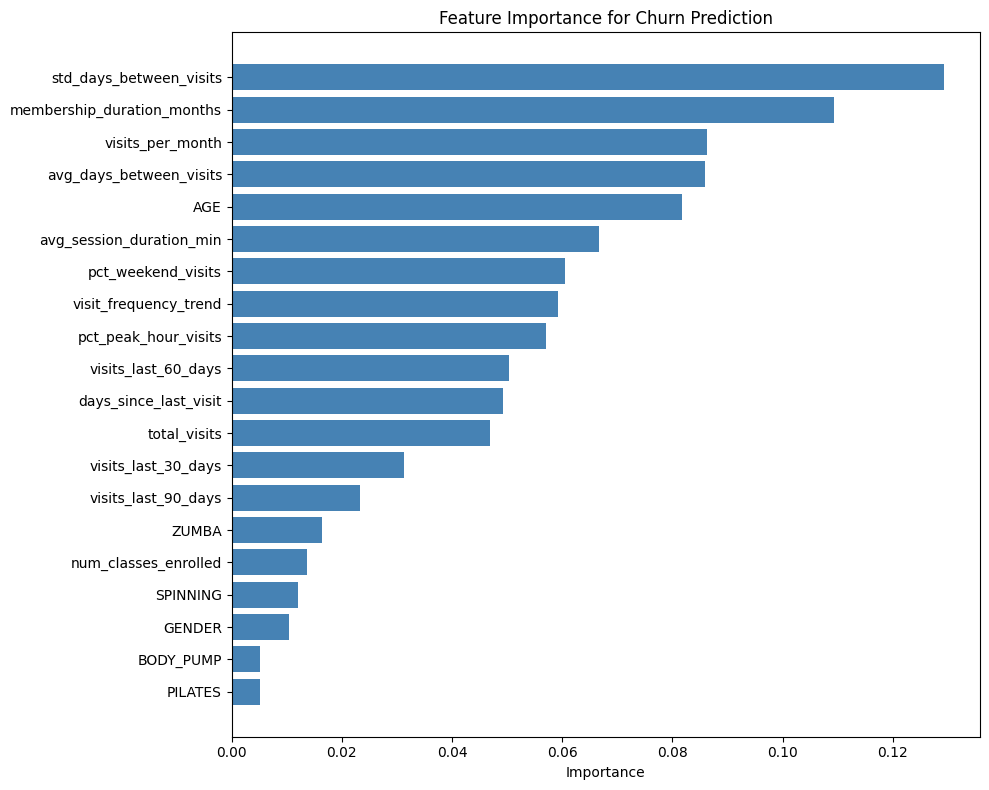


=== TOP 5 CHURN PREDICTORS ===
  std_days_between_visits: 0.129
  membership_duration_months: 0.109
  visits_per_month: 0.086
  avg_days_between_visits: 0.086
  AGE: 0.082


In [6]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Churn Prediction')
plt.tight_layout()
plt.show()

print("\n=== TOP 5 CHURN PREDICTORS ===")
for _, row in importance_df.tail(5).iloc[::-1].iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")


## Churned vs Active Users Comparison

Let's compare the behavior patterns between users who churned and those who stayed.


In [7]:
# Compare key metrics between churned and active users
comparison_cols = ['visits_per_month', 'days_since_last_visit', 'avg_session_duration_min', 
                   'visit_frequency_trend', 'num_classes_enrolled']

churned = features_df[features_df['CHURNED'] == 1]
active = features_df[features_df['CHURNED'] == 0]

print("=== BEHAVIOR COMPARISON: CHURNED vs ACTIVE ===\n")
for col in comparison_cols:
    print(f"{col}:")
    print(f"  Churned: {churned[col].mean():.2f} (median: {churned[col].median():.2f})")
    print(f"  Active:  {active[col].mean():.2f} (median: {active[col].median():.2f})")
    print()


=== BEHAVIOR COMPARISON: CHURNED vs ACTIVE ===

visits_per_month:
  Churned: 3.34 (median: 1.46)
  Active:  1.33 (median: 0.58)

days_since_last_visit:
  Churned: 36.41 (median: 18.00)
  Active:  60.83 (median: 29.50)

avg_session_duration_min:
  Churned: 62.01 (median: 61.31)
  Active:  62.07 (median: 61.29)

visit_frequency_trend:
  Churned: 0.21 (median: 0.00)
  Active:  0.17 (median: 0.00)

num_classes_enrolled:
  Churned: 0.94 (median: 1.00)
  Active:  0.88 (median: 1.00)



## Identify At-Risk Active Users

Use the trained model to find currently active users who show similar patterns to those who churned.


In [8]:
# Predict churn risk for active users
active_users = features_df[features_df['CHURNED'] == 0].copy()
active_users['churn_risk'] = model.predict_proba(active_users[feature_columns])[:, 1]

# Categorize risk levels
active_users['risk_level'] = pd.cut(
    active_users['churn_risk'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low', 'Medium', 'High']
)

print("=== RISK DISTRIBUTION (Active Users) ===")
print(active_users['risk_level'].value_counts())

print("\n=== TOP 10 AT-RISK USERS ===")
at_risk = active_users.nlargest(10, 'churn_risk')[['USER_ID', 'churn_risk', 'visits_per_month', 
                                                    'days_since_last_visit', 'visit_frequency_trend']]
print(at_risk.to_string(index=False))


=== RISK DISTRIBUTION (Active Users) ===
risk_level
Low       144
Medium     40
High        6
Name: count, dtype: int64

=== TOP 10 AT-RISK USERS ===
 USER_ID  churn_risk  visits_per_month  days_since_last_visit  visit_frequency_trend
   62565    0.764410         10.000000                     11              -0.727273
   82132    0.731683          0.798935                    118               0.857143
   69177    0.711691          2.051282                     25               0.666667
   80381    0.691958          6.176471                      8              -0.444444
   57819    0.641422          3.090909                      5              -0.692308
   87236    0.629031          2.443439                      3               1.000000
   96374    0.587212          9.375000                      0               0.500000
   60432    0.565744          2.334630                      3              -0.333333
   11504    0.544571          2.955665                     22               0.000000
